## 랜덤 포레스트(Random Forest)

In [1]:
import pandas as pd 
feature_name_df = pd.read_csv('../00_data/UCI_HAR_Dataset/features.txt', sep='\s+',
                             header=None, names=['col_index', 'col_name'])

In [2]:
def get_new_feature_name_df(old_df):
    dup_df = pd.DataFrame({'dup_cnt':feature_name_df.groupby('col_name').cumcount()})
    new_df = pd.merge(old_df.reset_index(), dup_df.reset_index())
    new_df['col_name'] = new_df[['col_name', 'dup_cnt']].\
        apply(lambda x: x[0]+'_'+str(x[1]) if x[1] > 0 else x[0], axis=1)
    new_df = new_df.drop(['index'], axis=1)
    return new_df

In [3]:
new_feature_df = get_new_feature_name_df(feature_name_df)
feature_list = list(new_feature_df.col_name.values)

In [4]:
X_train = pd.read_csv('../00_data/UCI_HAR_Dataset/train/X_train.txt', 
                           header=None, delim_whitespace=True, names=feature_list)
X_test = pd.read_csv('../00_data/UCI_HAR_Dataset/test/X_test.txt', 
                           header=None, delim_whitespace=True, names=feature_list)
y_train = pd.read_csv('../00_data/UCI_HAR_Dataset/train/y_train.txt', 
                           header=None, delim_whitespace=True, names=['action'])
y_test = pd.read_csv('../00_data/UCI_HAR_Dataset/test/y_test.txt', 
                           header=None, delim_whitespace=True, names=['action'])

### 랜덤 포레스트 모델 생성/학습/예측/평가

In [5]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

rf_clf = RandomForestClassifier()
rf_clf.fit(X_train, y_train)
pred = rf_clf.predict(X_test)
acc = accuracy_score(y_test, pred)
print(f'랜덤 포레스트 정확도: {acc:.4f}')

랜덤 포레스트 정확도: 0.9226


In [6]:
rf_clf.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

### GridSearchCV로 최적의 하이퍼 파라미터 도출

In [16]:
from sklearn.model_selection import GridSearchCV

params = {
    'n_estimators': [10, 50, 100],
    'max_depth': [8, 12, 16],
    'min_samples_split': [12, 16, 20]
}

In [17]:
rf_clf = RandomForestClassifier(random_state=156, n_jobs=-1)
grid_cv = GridSearchCV(rf_clf, param_grid=params, cv=3, n_jobs=-1)
grid_cv.fit(X_train, y_train)
print(f'최고 평균 정확도: {grid_cv.best_score_:.4f}')
print('최적 파라미터:', grid_cv.best_params_)

최고 평균 정확도: 0.9146
최적 파라미터: {'max_depth': 8, 'min_samples_split': 12, 'n_estimators': 50}


In [21]:
df = pd.DataFrame(grid_cv.cv_results_)
df = df[['param_n_estimators', 'param_max_depth', 'param_min_samples_split', 'mean_test_score']]
df

,param_n_estimators,param_max_depth,param_min_samples_split,mean_test_score
0,10,8,12,0.897850
1,50,8,12,0.914581
2,100,8,12,0.911861
3,10,8,16,0.897579
4,50,8,16,0.907781
5,100,8,16,0.909414
6,10,8,20,0.898532
7,50,8,20,0.911317
8,100,8,20,0.907510
9,10,12,12,0.891459


- 튜닝된 파라미터로 재평가

In [22]:
best_clf = grid_cv.best_estimator_
pred = best_clf.predict(X_test)
acc = accuracy_score(y_test, pred)
print(f'최적 파라미터 랜덤 포레스트 정확도: {acc:.4f}')

최적 파라미터 랜덤 포레스트 정확도: 0.9141


### 재탐색

In [23]:
params = {
    'n_estimators': [10, 50, 100]
}
rf_clf = RandomForestClassifier(random_state=156, n_jobs=-1)
grid_cv = GridSearchCV(rf_clf, param_grid=params, cv=3, n_jobs=-1)
grid_cv.fit(X_train, y_train)
print(f'최고 평균 정확도: {grid_cv.best_score_:.4f}')
print('최적 파라미터:', grid_cv.best_params_)

최고 평균 정확도: 0.9085
최적 파라미터: {'n_estimators': 50}


In [ ]:
best_clf = grid_cv.best_estimator_
pred = best_clf.predict(X_test)
acc = accuracy_score(y_test, pred)
print(f'최적 파라미터 랜덤 포레스트 정확도: {acc:.4f}')

### K 최근접 이웃(K-Nearest Neighbor)

In [14]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()
knn.get_params()

{'algorithm': 'auto',
 'leaf_size': 30,
 'metric': 'minkowski',
 'metric_params': None,
 'n_jobs': None,
 'n_neighbors': 5,
 'p': 2,
 'weights': 'uniform'}

In [15]:
knn.fit(X_train, y_train)
pred = knn.predict(X_test)
accuracy_score(y_test, pred)

0.9015948422124194

### 중요도가 높은 Feature 시각화

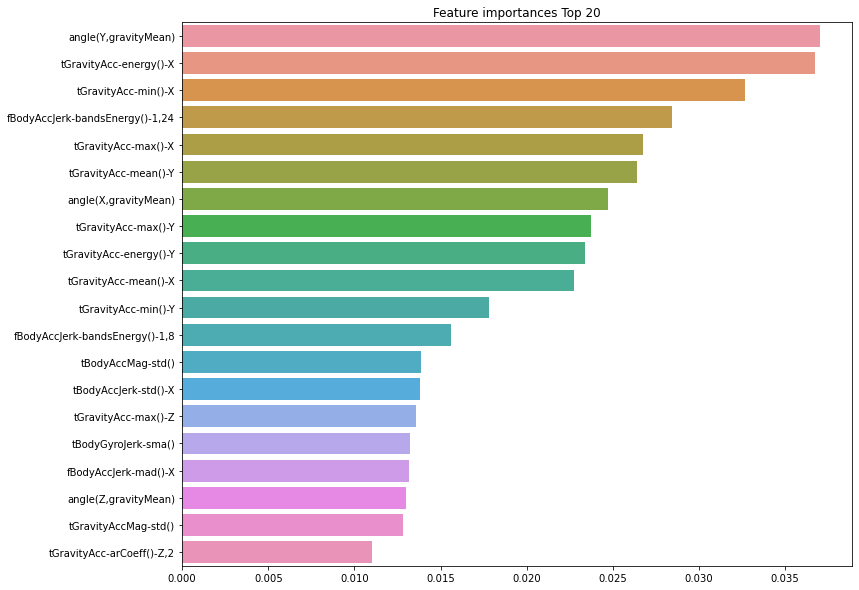

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns

feature_importances = pd.Series(best_clf.feature_importances_, index=feature_list)
top20_feature = feature_importances.sort_values(ascending=False)[:20]
plt.figure(figsize=(12,10))
plt.title('Feature importances Top 20')
sns.barplot(x=top20_feature, y=top20_feature.index)
plt.show()